In [1]:
!cat sbatch_parallel_gridding.sbatch

#!/bin/sh -l
# FILENAME:  gridding2

#SBATCH -A dawson29

#SBATCH -o /home/syed44/PERiLS/doppler_analysis/gridding/parallel_gridding.out

#SBATCH --nodes=4
#SBATCH -c 100
#SBATCH --time=72:00:00

# Print the hostname of the compute node on which this job is running.
/bin/hostname


module use /depot/dawson29/data/Projects/PERiLS/etc/modules/
module load conda-env/perils-py3.8.5

python /home/syed44/PERiLS/doppler_analysis/gridding/parallel_gridding.py

In [2]:
!cat parallel_gridding.py

import warnings
warnings.filterwarnings("ignore")
import pyart
import numpy as np
from pyart.retrieve import get_freq_band
from matplotlib import pyplot as plt
import glob, os
from datetime import datetime
import time
import sys

nexrad_dir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/NEXRAD/"


def _drop_fields(radar):
    fields_to_drop = ["PURPLE_HAZE"]
    for field in fields_to_drop:
        if field in radar.fields:
            del radar.fields[field]

    return radar


#function to dealiase the Doppler velocity
def dealiase(radar, vel_name='velocity', gatefilter=None, method="unwrap"):
    '''
    Dealias Doppler velocities using Py-ART.
    method : str
        Method to use for the dealiasing. Can be 'unwrap' or 'region'.
    '''
    # Create a GateFilter if one was not provided
    if gatefilter is None:
        gatefilter = pyart.correct.GateFilter(radar)
        gatefilter.include_above("REF", 0)
        gatefilter.exclude_masked('REF')
        gatefilter.exclude_i

In [4]:
import warnings
warnings.filterwarnings("ignore")
import pyart
import numpy as np
from pyart.retrieve import get_freq_band
from matplotlib import pyplot as plt
import glob, os
from datetime import datetime
import time
import xarray as xr
# from pymeso import llsd
# import scipy

In [5]:
kgwx = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/NEXRAD/GRID_DASK/IOP2/KGWX/"

In [6]:
filess = glob.glob(kgwx+"*")

In [ ]:
# # Use list comprehension to read in each file and convert to xarray dataset.
# grids = [pyart.io.read_grid(file).to_xarray() for file in filess]
# ds = xr.concat(grids, dim='time')

In [9]:
len(filess)

54

In [11]:
ds = xr.open_mfdataset(filess)

In [7]:
def rain_rate(ds, dbz='REF', a=300.0, b=1.4):
    """
    Calculates the rain rate from the input reflectivity data using the Marshall-Palmer relation.

    Parameters:
    ds (xarray.Dataset): The input dataset.
    dbz (str): The name of the variable containing the reflectivity data. Default value is 'REF'.
    a (float): The coefficient 'a' in the Marshall-Palmer relation. Default value is 300.
    b (float): The coefficient 'b' in the Marshall-Palmer relation. Default value is 1.4.

    Returns:
    xarray.Dataset: The input dataset with the new rain rate variable added.
    """
    # Calculate the rain rate from the input reflectivity data using the Marshall-Palmer relation
    z = 10.0 ** (ds[dbz] / 10.0)
    rr = (z / a) ** (1.0 / b)
    
    # Add the new rain rate variable to the input dataset
    ds['rain_rate'] = xr.DataArray(rr, dims=ds[dbz].dims, coords=ds[dbz].coords, name='rain_rate')
    
    return ds

In [12]:
ds = rain_rate(ds)

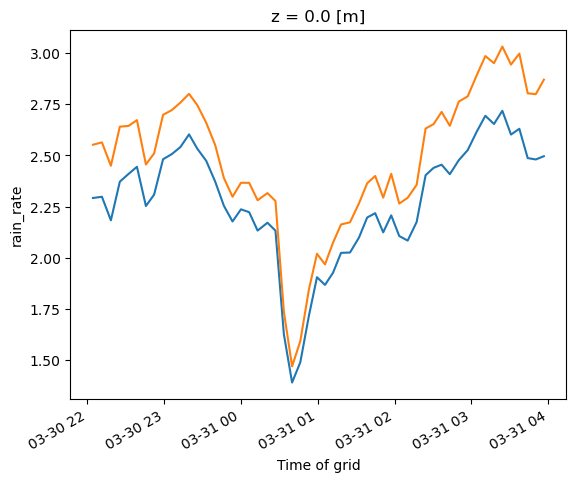

In [20]:
ds['rain_rate'].isel(z=3).mean(dim=['y','x']).plot()
ds['rain_rate'].isel(z=0).mean(dim=['y','x']).plot()